In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from re import sub # For price conversions
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# For calculations
from sklearn import tree
from sklearn.neighbors import BallTree
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression

import string
import warnings
warnings.filterwarnings('ignore')

# Clean DataSet

In [2]:
df = pd.read_csv('data/listings.csv')
# print(df.columns)
# Remove unnecessary columns
df = df[['id', 'name', 'description', 'latitude', 'longitude', 'price', 'room_type', 'bedrooms']]
df.rename(columns={'latitude': 'lat', 'longitude': 'lon'}, inplace=True)
df.head()

,id,name,description,lat,lon,price,room_type,bedrooms
0,71609,Ensuite Room (Room 1 & 2) near EXPO,For 3 rooms.Book room 1&2 and room 4<br /><br ...,1.34537,103.95887,"$46,437.00",Private room,2.0
1,71896,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,1.34754,103.95958,$81.00,Private room,1.0
2,71903,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",1.34531,103.96100,$81.00,Private room,1.0
3,275343,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,1.29015,103.80814,$52.00,Private room,1.0
4,275344,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,1.28836,103.81144,$49.00,Private room,1.0


### Fix listingDF price `string->int`

In [3]:
print("Before cleaing:", df.price.count(), df.price.dtype)
df['price'] = df.price.map(lambda x: float(sub(r'[^\d.]', '', x)))
print("After cleaning:", df.price.count(), df.price.dtype)

Before cleaing: 3037 object
After cleaning: 3037 float64


### Trim outliers and $0 rental prices

In [4]:
# Remove $0 rental
df = df.query('price != 0')
# Remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
df['price'].describe()

count    2772.000000
mean      179.460317
std       132.364542
min        13.000000
25%        70.000000
50%       146.000000
75%       244.250000
max       629.000000
Name: price, dtype: float64

Filter out rooms with more than 1 bed.

# Feature Engineering

Let new_price = price / bedrooms (accounting for shared rental)

private room:
    - 1 person room is much more valuable
    - 2 people room is slightly more valuable
    - 3+ people room grows linearly 

entire house:
    - 1 person house is much more valuable
    - 2+ people house is less valuable 

Private room       1384
Entire home/apt    1152
Hotel room          121
Shared room         115
Name: room_type, dtype: int64

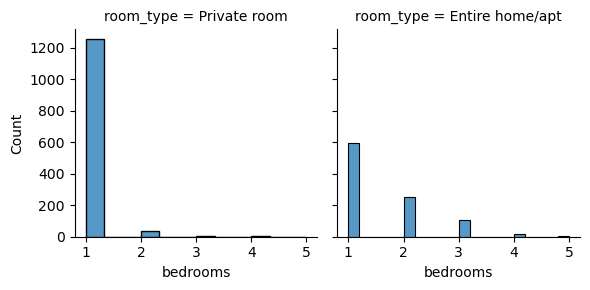

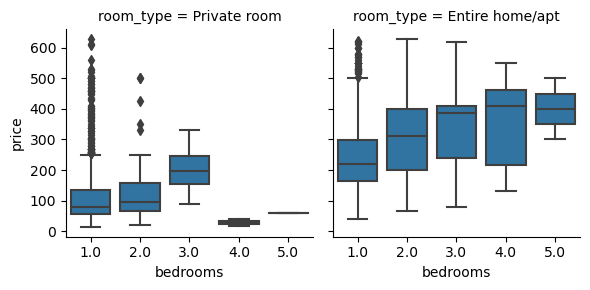

In [5]:
display(df['room_type'].value_counts())
# Discard hotel room and shared room
df = df[df['room_type'] != 'Shared room']
df = df[df['room_type'] != 'Hotel room']
# Plot against different number of bedrooms
# First, number of each type of bedrooms
g = sns.FacetGrid(df, col='room_type')
g.map(sns.histplot, 'bedrooms')
# Then, price range of each type of bedrooms
g = sns.FacetGrid(df, col='room_type')
g.map(sns.boxplot, 'bedrooms', 'price')

Hence, we can delete all private room listing with more than one bedrooms.

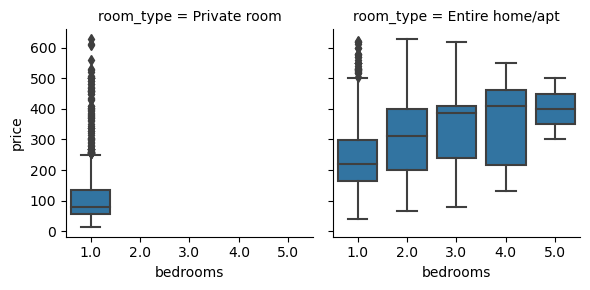

In [6]:
df = df.drop(df[(df['room_type'] == 'Private room') & (df['bedrooms'] > 1)].index)
g = sns.FacetGrid(df, col='room_type')
g.map(sns.boxplot, 'bedrooms', 'price')

### Visualisation

<Axes: xlabel='price', ylabel='Count'>

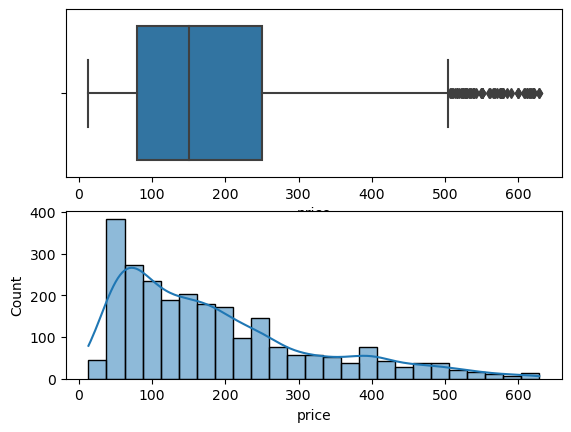

In [7]:
fig, (ax1, ax2) = plt.subplots(2)
sns.boxplot(ax=ax1, x=df['price'], orient='h')
sns.histplot(ax=ax2, data=df, x='price', kde=True)

We can see that AirBNB price per night is $180+-132.

# Using Classification Tree

<Axes: xlabel='price', ylabel='Count'>

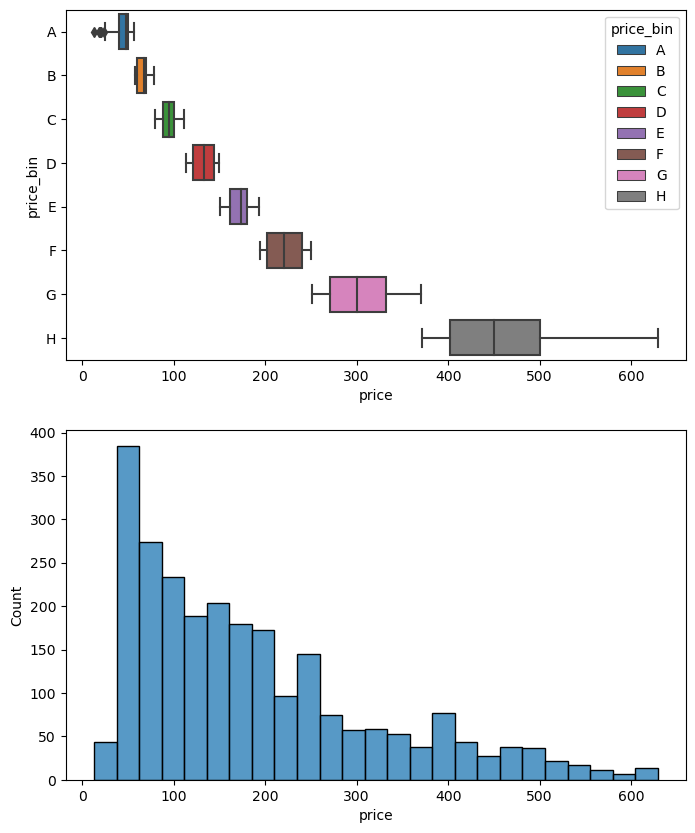

In [8]:
MAX_BINS = 8
bin_lbls = list(string.ascii_uppercase)[:MAX_BINS]
df['price_bin'] = pd.qcut(df['price'], q=MAX_BINS, labels=bin_lbls)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,10))
sns.boxplot(ax=ax1, data=df, x='price', y='price_bin', hue='price_bin', dodge=False)
sns.histplot(ax=ax2, data=df, x='price')

Score: 0.3106212424849699


<Axes: >

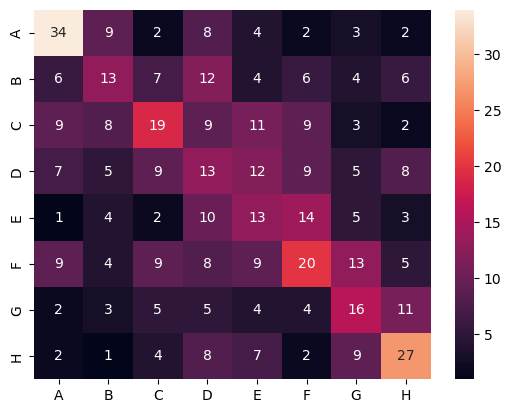

In [9]:
X = pd.concat([df.lat, df.lon], axis=1)
y = df.price_bin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print("Score:", clf.score(X=X_test, y=y_test))

C = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(C, xticklabels=bin_lbls, yticklabels=bin_lbls, annot=True)

# Using K-Nearest Neighbours (Ball Tree)

Initalise map data from OpenStreetMap

In [10]:
city:gpd.GeoDataFrame = gpd.read_file('data/singapore.geojson')
common_filter = lambda x: ['osm_id', 'name', 'ref', f'{x}', 'other_tags', 'geometry', f'{x}']
city.head()

,osm_id,name,ref,amenity,highway,shop,leisure,railway,other_tags,geometry
0,25451918,NaN,2A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97394 1.32757)
1,25455287,NaN,14A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.87400 1.29544)
2,25455292,NaN,10B,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.90850 1.30101)
3,25455304,NaN,1,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97848 1.33468)
4,26778790,NaN,NaN,NaN,traffic_signals,NaN,NaN,NaN,NaN,POINT (103.85002 1.30152)


Filter out dataframe for different amenities.

First, let's filter out MRT.

In [11]:
mrt = city.filter(items=common_filter('railway'))
mrt.query('railway == "station"', inplace=True) # Includes Sentosa monorail too
mrt.head()

,osm_id,name,ref,railway,other_tags,geometry,railway
195,206477134,Aljunied,EW9,station,"""name:en""=>""Aljunied"",""name:ms""=>""Aljunied"",""n...",POINT (103.88291 1.31645),station
196,206493462,Kallang,EW10,station,"""air_conditioning""=>""no"",""name:en""=>""Kallang"",...",POINT (103.87134 1.31147),station
197,206529415,Yio Chu Kang,NS15,station,"""addr:city""=>""Singapore"",""addr:housenumber""=>""...",POINT (103.84494 1.38179),station
206,207725954,Tanah Merah,EW4,station,"""name:en""=>""Tanah Merah"",""name:ja""=>""タナ・メラ駅"",""...",POINT (103.94650 1.32726),station
207,207725957,Bedok,EW5,station,"""addr:city""=>""Singapore"",""addr:housenumber""=>""...",POINT (103.93022 1.32398),station


Next, lets filter out bus stops.

In [12]:
bus = city.filter(items=common_filter('highway'))
bus.query('highway == "bus_stop"', inplace=True)
bus.head()

,osm_id,name,ref,highway,other_tags,geometry,highway
1969,382902010,Westgate-IMM Shuttle,NaN,bus_stop,"""bench""=>""yes"",""bus""=>""yes"",""covered""=>""yes"",""...",POINT (103.74701 1.33621),bus_stop
2165,410458893,After The Japanese Association,41139,bus_stop,"""bench""=>""yes"",""bin""=>""no"",""bus""=>""yes"",""lit""=...",POINT (103.81490 1.32961),bus_stop
2166,410458894,After Adam Drive,41141,bus_stop,"""bus""=>""yes"",""location""=>""Adam Road"",""public_t...",POINT (103.81798 1.33491),bus_stop
2167,410458896,Singapore Bible Coll,41121,bus_stop,"""bus""=>""yes"",""location""=>""Adam Road"",""public_t...",POINT (103.81352 1.32551),bus_stop
2168,410458897,Opposite Singapore Bible Coll,41129,bus_stop,"""bench""=>""yes"",""bin""=>""yes"",""bus""=>""yes"",""lit""...",POINT (103.81401 1.32545),bus_stop


Lets filter out malls.

In [13]:
mall = city.filter(items=common_filter('shop'))
mall.query('shop == "mall"', inplace=True)
mall.head()

,osm_id,name,ref,shop,other_tags,geometry,shop
17082,4233370769,Bencoolen Underground Mall,NaN,mall,"""air_conditioning""=>""yes""",POINT (103.84965 1.29818),mall
17083,4233370770,Bencoolen Underground Mall,NaN,mall,"""air_conditioning""=>""yes""",POINT (103.85076 1.29922),mall
21041,4682788852,Katong V,NaN,mall,"""addr:street""=>""Marine Parade Road""",POINT (103.90323 1.30313),mall
39693,6440064328,The Poiz Centre,NaN,mall,"""addr:city""=>""Singapore"",""addr:housenumber""=>""...",POINT (103.86857 1.33144),mall
74638,9084196506,Clarke Quay Central,NaN,mall,"""addr:city""=>""Singapore"",""addr:housenumber""=>""...",POINT (103.84618 1.28900),mall


Lets filter out schools.

In [14]:
school = city.filter(items=common_filter('amenity'))
school.query('amenity == "school"', inplace=True)
school.head()

,osm_id,name,ref,amenity,other_tags,geometry,amenity
6370,521081225,ACC EduHub,NaN,school,"""addr:housenumber""=>""51""",POINT (103.84038 1.30280),school
7009,1080233666,NaN,NaN,school,NaN,POINT (103.79829 1.30354),school
8427,1703872641,Hua Language Centre,NaN,school,"""addr:unit""=>""02-09"",""contact:phone""=>""+656255...",POINT (103.86969 1.38727),school
8428,1703872645,Jan & Elly English Language School,NaN,school,"""addr:unit""=>""02-10"",""contact:phone""=>""6762778...",POINT (103.86962 1.38727),school
9170,1800164471,NaN,NaN,school,NaN,POINT (103.83793 1.33863),school


Lastly, lets filter out food places.

In [15]:
food = city.filter(items=common_filter('amenity'))
food.query('amenity == "food_restaurant" | amenity == "restaurant"', inplace=True)
food.head()

,osm_id,name,ref,amenity,other_tags,geometry,amenity
1878,370791987,NaN,NaN,restaurant,NaN,POINT (103.89834 1.37508),restaurant
1963,380582666,Suki-ya,NaN,restaurant,"""addr:city""=>""Singapore"",""addr:housenumber""=>""...",POINT (103.88548 1.35949),restaurant
6280,462263947,Jumbo Seafood,NaN,restaurant,"""addr:city""=>""Singapore"",""addr:country""=>""SG"",...",POINT (103.93068 1.30515),restaurant
6285,462264013,Jumbo Seafood Gallery,NaN,restaurant,"""cuisine""=>""asian"",""wheelchair""=>""yes""",POINT (103.84830 1.28929),restaurant
6336,512070755,Hooters,NaN,restaurant,"""brand""=>""Hooters"",""brand:wikidata""=>""Q1025921...",POINT (103.84588 1.28996),restaurant


In [16]:
# Creates new columns converting coordinate degrees to radians.
def degree_to_radians(data: gpd.GeoDataFrame)->None:
    if not {'lat', 'lon'}.issubset(data.columns):
        geometry_to_coordinates(data)
    for column in ['lat','lon']:
        data[column] = np.deg2rad(data[column].values)

def geometry_to_coordinates(data: gpd.GeoDataFrame)->None:
    data['lon'] = data.geometry.x
    data['lat'] = data.geometry.y

def find_closest(data: gpd.GeoDataFrame, name="_")->pd.Series:
    # Check if 'lat' and 'lon' exists in data and df
    if not {'lat','lon'}.issubset(data.columns):
        degree_to_radians(data)
    # Construct ball tree
    bT = BallTree(data[['lat', 'lon']].values, metric='haversine')
    # Grab the first nearest neighbour (distance only)
    distances, _ = bT.query(df[['lat', 'lon']].values, k=1)
    # Convert distances to km
    distances = np.squeeze(distances)
    convert_to_km = np.vectorize(lambda x: x * 6371)
    distances = convert_to_km(distances)
    return pd.Series(distances, name=name)

# Convert dataset to radians
degree_to_radians(df)

### Then we can do linear regression!

In [17]:
df.reset_index(inplace=True)

df = pd.concat([df, find_closest(mrt, "distance_from_MRT")], axis=1)
df.head()

,index,id,name,description,lat,lon,price,room_type,bedrooms,price_bin,distance_from_MRT
0,1,71896,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,0.023519,1.814437,81.0,Private room,1.0,C,0.842953
1,2,71903,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",0.023480,1.814462,81.0,Private room,1.0,C,0.880282
2,3,275343,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,0.022517,1.811794,52.0,Private room,1.0,A,0.549557
3,4,275344,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,0.022486,1.811851,49.0,Private room,1.0,A,0.609339
4,6,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,0.022889,1.812337,79.0,Private room,1.0,B,3.478741


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   index              2495 non-null   int64   
 1   id                 2495 non-null   int64   
 2   name               2495 non-null   object  
 3   description        2453 non-null   object  
 4   lat                2495 non-null   float64 
 5   lon                2495 non-null   float64 
 6   price              2495 non-null   float64 
 7   room_type          2495 non-null   object  
 8   bedrooms           2224 non-null   float64 
 9   price_bin          2495 non-null   category
 10  distance_from_MRT  2495 non-null   float64 
dtypes: category(1), float64(5), int64(2), object(3)
memory usage: 197.8+ KB


Start by visualising the data.

<Axes: xlabel='distance_from_MRT', ylabel='price'>

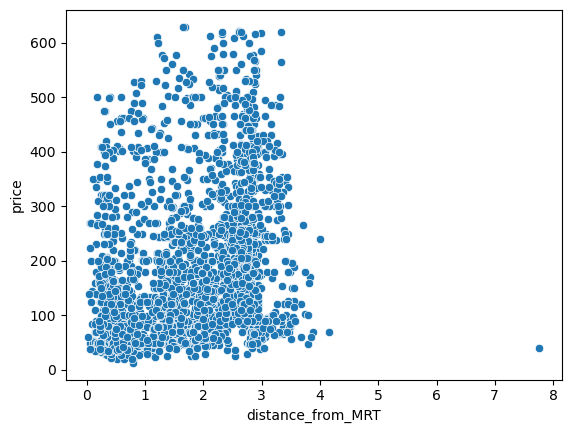

In [19]:
sns.scatterplot(df, x='distance_from_MRT', y='price')

Another variable!

In [20]:
df = pd.concat([df, find_closest(bus, "distance_from_Bus")], axis=1)
df.head()

,index,id,name,description,lat,lon,price,room_type,bedrooms,price_bin,distance_from_MRT,distance_from_Bus
0,1,71896,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,0.023519,1.814437,81.0,Private room,1.0,C,0.842953,0.180102
1,2,71903,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",0.023480,1.814462,81.0,Private room,1.0,C,0.880282,0.205346
2,3,275343,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,0.022517,1.811794,52.0,Private room,1.0,A,0.549557,0.117975
3,4,275344,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,0.022486,1.811851,49.0,Private room,1.0,A,0.609339,0.040906
4,6,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,0.022889,1.812337,79.0,Private room,1.0,B,3.478741,0.080014


<Axes: xlabel='distance_from_Bus', ylabel='price'>

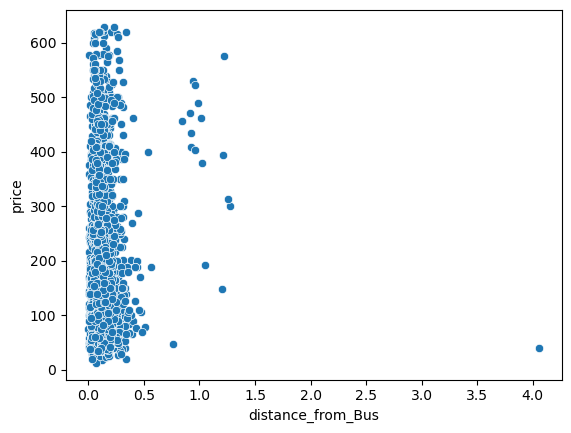

In [21]:
sns.scatterplot(df, x='distance_from_Bus', y='price')